In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Competition and Data
https://www.kaggle.com/competitions/digit-recognizer/overview

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

ImageId,Label
1,3
2,7
3,8 
(27997 more lines)
The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

# Setup

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')

In [3]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
train_path = "/kaggle/input/digit-recognizer/train.csv"
train_data = pd.read_csv(train_path)
test_path = "/kaggle/input/digit-recognizer/test.csv"
test_data = pd.read_csv(test_path)

In [5]:
# test.csv has doesn't have true target values.
print(train_data.shape)
print(test_data.shape)

# rename test_data to pred_data
pred_data = test_data

(42000, 785)
(28000, 784)


# Exploratory Data Analysis

In [6]:
train_images = train_data.drop(columns=["label"], inplace=False)
train_labels = train_data.label

test_images = test_data
test_data.shape

(28000, 784)

In [7]:
# Images per digit
train_labels.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [8]:
# Maximum pixel value
train_images.to_numpy().max()

255

In [9]:
# Normalize
train_images /= 255
test_images /= 255

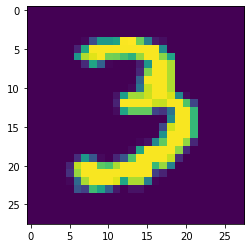

In [10]:
def show_image(index, images):
    image = images.iloc[index].to_numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image)
    plt.show()
    
show_image(9, train_images)

# Training, Validation, Test Sets
The validation set will be created from the training set when fitting the models. <br>
Cross-validation is not necessary for large datasets.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
    
    # get training and validation losses from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot the training and validation losses
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# ANN/FNN

In [14]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(784, activation='relu', input_shape=[784]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_fnn.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])

model_fnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_fnn', monitor='val_loss', mode='min', save_best_only=True)
]

history_fnn = model_fnn.fit(X_train, y_train, epochs=25, validation_split=0.2, callbacks=callbacks)
best_fnn = tf.keras.models.load_model('best_fnn')

Epoch 1/25
945/945 [==============================] - 3s 2ms/step - loss: 0.2690 - accuracy: 0.9194 - val_loss: 0.1367 - val_accuracy: 0.9612
Epoch 2/25
945/945 [==============================] - 2s 2ms/step - loss: 0.1134 - accuracy: 0.9646 - val_loss: 0.1071 - val_accuracy: 0.9679
Epoch 3/25
945/945 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9764 - val_loss: 0.1091 - val_accuracy: 0.9696
Epoch 4/25
945/945 [==============================] - 2s 2ms/step - loss: 0.0565 - accuracy: 0.9826 - val_loss: 0.1127 - val_accuracy: 0.9672
Epoch 5/25
945/945 [==============================] - 2s 2ms/step - loss: 0.0449 - accuracy: 0.9855 - val_loss: 0.1033 - val_accuracy: 0.9720
Epoch 6/25
945/945 [==============================] - 2s 2ms/step - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.1215 - val_accuracy: 0.9704
Epoch 7/25
945/945 [==============================] - 2s 2ms/step - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.1245 - val_accuracy: 0.9683
Epoch 

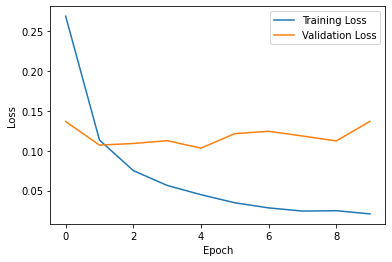

In [16]:
plot_loss(history=history_fnn)

# CNN

In [17]:
X_train_cnn = X_train.values.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.values.reshape(-1, 28, 28, 1)
print(X_train_cnn.shape)

(37800, 28, 28, 1)


In [18]:
model_cnn = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model_cnn.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])

print(X_test_cnn.shape)
print(y_test.shape)
model_cnn.summary()

(4200, 28, 28, 1)
(4200,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)           

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_cnn', monitor='val_loss', mode='min', save_best_only=True)
]

history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=25, validation_split=0.2, callbacks=callbacks)

best_cnn = tf.keras.models.load_model('best_cnn')

Epoch 1/25
945/945 [==============================] - 9s 4ms/step - loss: 0.7507 - accuracy: 0.7318 - val_loss: 0.1995 - val_accuracy: 0.9501
Epoch 2/25
945/945 [==============================] - 3s 3ms/step - loss: 0.1333 - accuracy: 0.9622 - val_loss: 0.1158 - val_accuracy: 0.9681
Epoch 3/25
945/945 [==============================] - 3s 3ms/step - loss: 0.0871 - accuracy: 0.9743 - val_loss: 0.0926 - val_accuracy: 0.9741
Epoch 4/25
945/945 [==============================] - 3s 3ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0738 - val_accuracy: 0.9792
Epoch 5/25
945/945 [==============================] - 3s 3ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.0765 - val_accuracy: 0.9776
Epoch 6/25
945/945 [==============================] - 3s 3ms/step - loss: 0.0364 - accuracy: 0.9889 - val_loss: 0.0738 - val_accuracy: 0.9798
Epoch 7/25
945/945 [==============================] - 3s 3ms/step - loss: 0.0253 - accuracy: 0.9919 - val_loss: 0.0611 - val_accuracy: 0.9837
Epoch 

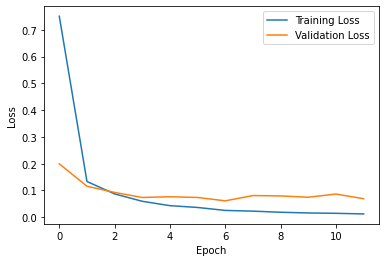

In [20]:
plot_loss(history=history_cnn)

# CCN with pretrained base

In [21]:
def preprocess_rgb(data):
    data = data.values.reshape(-1, 28, 28)
    data = tf.image.grayscale_to_rgb(tf.expand_dims(data, axis=-1)) # -1 vs 3
    data = tf.image.resize_with_pad(data, 32, 32)
    return data

X_train_pt = preprocess_rgb(X_train)
X_test_pt = preprocess_rgb(X_test)
X_train_pt.shape

TensorShape([37800, 32, 32, 3])

In [22]:
pretrained_base = tf.keras.applications.VGG16(input_shape=(32, 32, 3), weights='imagenet', include_top=False)
pretrained_base.trainable = False

58900480/58889256 [==============================] - 2s 0us/step


In [23]:
model_pt = tf.keras.Sequential([
    pretrained_base,
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(10, activation='softmax')
])

model_pt.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])

model_pt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
____________________________________

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_pt', monitor='val_loss', mode='min', save_best_only=True)
]

history_pt = model_pt.fit(X_train_pt, y_train, epochs=25, validation_split=0.2, callbacks=callbacks)

best_pt = tf.keras.models.load_model('best_pt')

Epoch 1/25
945/945 [==============================] - 10s 10ms/step - loss: 0.4158 - accuracy: 0.8660 - val_loss: 0.2020 - val_accuracy: 0.9364
Epoch 2/25
945/945 [==============================] - 8s 8ms/step - loss: 0.2352 - accuracy: 0.9224 - val_loss: 0.1652 - val_accuracy: 0.9471
Epoch 3/25
945/945 [==============================] - 8s 8ms/step - loss: 0.2075 - accuracy: 0.9304 - val_loss: 0.1753 - val_accuracy: 0.9444
Epoch 4/25
945/945 [==============================] - 8s 8ms/step - loss: 0.1903 - accuracy: 0.9360 - val_loss: 0.1452 - val_accuracy: 0.9529
Epoch 5/25
945/945 [==============================] - 8s 8ms/step - loss: 0.1762 - accuracy: 0.9422 - val_loss: 0.1376 - val_accuracy: 0.9538
Epoch 6/25
945/945 [==============================] - 8s 8ms/step - loss: 0.1643 - accuracy: 0.9442 - val_loss: 0.1313 - val_accuracy: 0.9554
Epoch 7/25
945/945 [==============================] - 8s 8ms/step - loss: 0.1579 - accuracy: 0.9468 - val_loss: 0.1347 - val_accuracy: 0.9542
Epoc

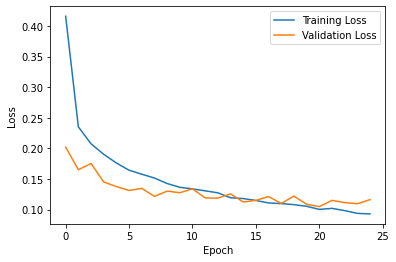

In [25]:
plot_loss(history=history_pt)

# Model comparison

In [26]:
# ANN/FNN
test_loss_ann, test_acc_ann = best_fnn.evaluate(X_test, y_test) 

# CNN
test_loss_cnn, test_acc_cnn = best_cnn.evaluate(X_test.values.reshape(-1, 28, 28, 1), y_test) 

# CNN with Pretrained Base
X_test_pt = X_test.values.reshape(-1, 28, 28)
X_test_pt = tf.image.grayscale_to_rgb(tf.expand_dims(X_test_pt, axis=-1)) # -1 vs 3
X_test_pt = tf.image.resize_with_pad(X_test_pt, 32, 32)
test_loss_pt, test_acc_pt = best_pt.evaluate(X_test_pt, y_test) 

132/132 [==============================] - 1s 9ms/step - loss: 0.0849 - accuracy: 0.9717


# Best Model's (CNN) Metrics 

In [27]:
# Predictions for the CNN
pred_test = model_cnn.predict(X_test_cnn)
pred_test = np.argmax(pred_test, axis=1)
pred_test

array([8, 1, 9, ..., 7, 7, 5])

## Confusion Matrix

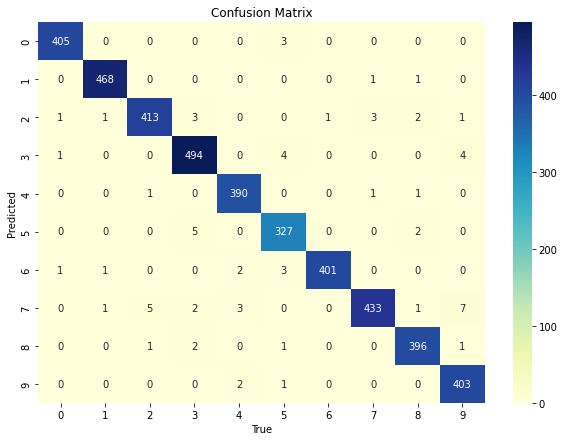

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_test, y_test)

fig = plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='d')
ax.set_title("Confusion Matrix")
ax.set_ylabel("Predicted")
ax.set_xlabel("True")
plt.show()

## Precision, Recall & F1-scores

In [29]:
from sklearn.metrics import classification_report

print(classification_report(pred_test, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       408
           1       0.99      1.00      0.99       470
           2       0.98      0.97      0.98       425
           3       0.98      0.98      0.98       503
           4       0.98      0.99      0.99       393
           5       0.96      0.98      0.97       334
           6       1.00      0.98      0.99       408
           7       0.99      0.96      0.97       452
           8       0.98      0.99      0.99       401
           9       0.97      0.99      0.98       406

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



# Predictions

In [30]:
submission_prob = model_cnn.predict(test_data.values.reshape(-1, 28, 28, 1))
submission_pred = np.argmax(submission_prob, axis=1)
submission_pred

array([2, 0, 9, ..., 3, 9, 2])

# Submission

In [31]:
submission = pd.Series(submission_pred, name='Label', index=range(1, len(submission_pred)+1)).to_frame()
submission.index.name='ImageId'
submission.to_csv("submission.csv")

# Prediction Visualizer

Prediction: 1


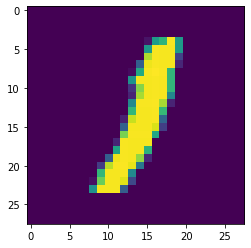

In [32]:
idx = np.random.randint(0, len(submission_pred))
print(f'Prediction: {submission_pred[idx]}')
show_image(idx, test_images)

# Ways to improve: 
* Pruning
* Synthetic data & oversampling